Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
from scipy.signal import periodogram
from math import floor
import pandas as pd

In [2]:
with open("promoterRanges_200-400.dict", 'rb') as f:
    promoter_ranges = pickle.load(f)
with open("nonPromotersDict_200-400.dict", 'rb') as f:
    non_promoter_ranges = pickle.load(f)

In [3]:
genome_file = 'genome_efull.txt'
genome = ''
with open(genome_file,'r') as f:
    for f in f.readlines():
        f = f.strip('\n')
        genome = genome+f

In [4]:
def get_strings(dictionary,genome):
    seqs = []
    for key in dictionary.keys():
        start,end = dictionary[key]
        seq = genome[start:end]
        seqs.append(seq)
    return(seqs)

CGR Signal Processing

In [5]:
def cgr_genome(genome,verbose = False):
    corner_dict = {'a': np.array([-1,-1]), 'c': np.array([-1,1]),
                   'g': np.array([1,1]), 't': np.array([1,-1])}
    genome = genome.lower()
    xpos = [0]
    ypos = [0]
    curr_pos = np.array([0.5,0.5])
    for i,gene in enumerate(genome):
        vert = corner_dict[gene]
        diff = vert-curr_pos
        diff = diff/2
        curr_pos = curr_pos + diff
        xpos.append(curr_pos[0])
        ypos.append(curr_pos[1])
        if verbose:
            if i%100 == 0:
                out_string = 'Progress: {}/{} \r'.format(i+1,len(genome))
                sys.stdout.write(out_string)
                sys.stdout.flush()
    return(xpos,ypos)
    

In [6]:
promoter_seqs = get_strings(promoter_ranges,genome)

In [7]:
nonpromoter_seqs = get_strings(non_promoter_ranges,genome)

In [8]:
x_prom = []
y_prom = []
for seq in promoter_seqs:
    x_pos,y_pos = cgr_genome(seq)
    x_prom.append(x_pos)
    y_prom.append(y_pos)

In [9]:
x_nonprom = []
y_nonprom = []
for seq in nonpromoter_seqs:
    x_pos,y_pos = cgr_genome(seq)
    x_nonprom.append(x_pos)
    y_nonprom.append(y_pos)

In [10]:
def extract_freq(data, num_feats = 5):
    feats = []
    for row in data:
        feat = []
        for d in row:
            n = len(d)
            val = np.fft.fft(d)
            val = val/n
            freq = np.fft.fftfreq(n,1)
            M = int(n/2)
            val = np.abs(val[:M])
            freq = freq[:M]
            sort_ind = np.argsort(val)
            for i in range(num_feats):
                feat.append(freq[sort_ind[i]])
                feat.append(val[sort_ind[i]])
        feats.append(feat)
    return(feats)
        

In [11]:
data = []
labels = []
for (x,y) in zip(x_prom,y_prom):
    data.append((x,y))
    labels.append(1)
for (x,y) in zip(x_nonprom,y_nonprom):
    data.append((x,y))
    labels.append(0)
features = extract_freq(data)

In [20]:
with open('tuple_data.tup', 'wb') as f:
    pickle.dump((features,labels), f)

In [12]:
import nolds as nds

In [29]:
example = [[x,y] for (x,y) in zip(x_prom[0],y_prom[0])]
ly = nds.lyap_e(x_nonprom[1])

In [30]:
print(ly)

[ 0.10083786  0.00761901 -0.08594161 -0.22792792]


Metric Dimension Signal Processing

In [13]:
R = ['00000','11301','02020','31100','11200','02010','11330','31000','00002','11303']
alphabet = {'0': 'A', '1':'C', '2':'T', '3':'G'}
decoded_R = []
for r in R:
    decoded_r = ''
    for c in r:
        new_c = alphabet[c]
        decoded_r = decoded_r+new_c
    decoded_R.append(decoded_r)

In [14]:
print(decoded_R)

['AAAAA', 'CCGAC', 'ATATA', 'GCCAA', 'CCTAA', 'ATACA', 'CCGGA', 'GCAAA', 'AAAAT', 'CCGAG']


In [15]:
def MD_encode(sequence,R, win = 5,step = 3):
    i = 0
    numerical_seq = []
    while i < len(sequence)-win:
        subseq = sequence[i:i+win-1]
        distVec = []
        for r in R:
            c = sum(1 for c1,c2 in zip(r,subseq) if c1 != c2) - 2.5
            distVec.append(c)
        numerical_seq.append(distVec)
        i = i+step
    return(numerical_seq)

In [16]:
num_promoters = []
for prom in promoter_seqs:
    num_seq = MD_encode(prom,decoded_R, win = 5, step = 3)
    num_promoters.append(num_seq)
num_nonpromoters = []
for nonprom in nonpromoter_seqs:
    num_seq = MD_encode(nonprom,decoded_R, win = 5, step = 3)
    num_nonpromoters.append(num_seq)

In [17]:
p1 = []
p2 = []
p3 = []
p4 = []
p5 = []
for seq in num_promoters:
    p1.append([n[0] for n in seq])
    p2.append([n[1] for n in seq])
    p3.append([n[2] for n in seq])
    p4.append([n[3] for n in seq])
    p5.append([n[4] for n in seq])

        
np1 = []
np2 = []
np3 = []
np4 = []
np5 = []
for seq in num_nonpromoters:
    np1.append([n[0] for n in seq])
    np2.append([n[1] for n in seq])
    np3.append([n[2] for n in seq])
    np4.append([n[3] for n in seq])
    np5.append([n[4] for n in seq])

In [21]:
def extract_freq(data, num_feats = 1, k = 3):
    feats = []
    for row in data:
        feat = []
        for d in row:
            n = len(d)
            val = np.fft.fft(d)
            val = val/n
            freq = np.fft.fftfreq(n,1)
            M = int(n/2)
            val = np.abs(val[:M])
            freq = freq[:M]
            sort_ind = np.argsort(val)
            for i in range(num_feats):
                feat.append(freq[sort_ind[i]])
                feat.append(val[sort_ind[i]])
        feats.append(feat)
    return(feats)
        

In [22]:
data = []
labels = []
for x in zip(p1,p2,p3,p4,p5):
    data.append(x)
    labels.append(1)
for x in zip(np1,np2,np3,np4,np5):
    data.append(x)
    labels.append(0)
features = extract_freq(data)

In [23]:
print(features[0])

[0.19337016574585636, 0.002247407552399378, 0.07734806629834254, 0.0009160468498664929, 0.3701657458563536, 0.009789777098931847, 0.4917127071823204, 0.0010763396607662234, 0.4198895027624309, 0.002452036702539897]


In [24]:
with open('MD_freqFeats.tup', 'wb') as f:
    pickle.dump((features,labels),f)

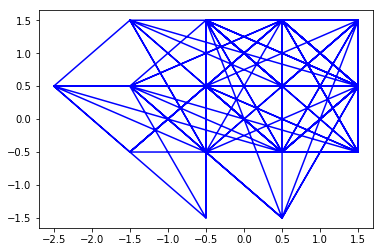

In [144]:
plt.plot(p1[0],p2[0],'b-')
plt.show()